### How to run Metrcs on DDF or areas that are outside WFD and DDF

In [1]:
# development code
%load_ext autoreload
%autoreload 2

### Software Setup (repeat each session)

In [2]:
# import common python packages
%matplotlib inline
import matplotlib.pyplot as plt
import os, sys, glob
import pandas as pd
import numpy as np

##### Detect and Set Your SciServer Username
__Note:__ Your usename will be used to store MAF output, so please make sure it is correct.

In [3]:
your_username = os.getcwd().split('/')[5]
print(f'Your automatically extracted username is: {your_username}.'
    ' If it is incorrect, please mannually reset it.')

Your automatically extracted username is: ywx649999311. If it is incorrect, please mannually reset it.


##### Import the $\texttt{rubin_sim}$ modules needed.

In [4]:
# import rubin_sim python modules
import rubin_sim.maf.db as db
import rubin_sim.maf.slicers as slicers
import rubin_sim.maf.metrics as metrics
import rubin_sim.maf.metricBundles as mb
import rubin_sim.maf.plots as plots
import rubin_sim.maf.batches as batches

# import convenience functions for MAF analysis on SciServer
from opsimUtils import *

# print version
import rubin_sim
rubin_sim.__version__

'0.7.1.dev169+g40b47c7'

### ProposalId
To run metrics on DDF or areas outside DDF and WFD, we need to set the `proposalId` in the sql contraint. In short, if running metric on DDFs only, `proposalId > 1`; if running metrics in areas outside DDF and WDF, `proposalId = 0`. We get all also run WFD only metrics using `proposalId = 1`, but a more sophisticated methods is shown in [wfdFootPrint.ipynb](./04_wfdFootPrint.ipynb). More discussion regarding running metrics on WFD observations only can be found in this [thread](https://community.lsst.org/t/wfd-metrics-with-the-fbs-output/3970).

The area associated with each `proposalId` for one particular cadence simulation is shown below:  
```sql
proposalId  proposalName  proposalType
----------  ------------  ------------
0           Other         Other
1           WFD           WFD
2           DD:COSMOS     DD
3           DD:ECDFS, b   DD
5           DD:XMM-LSS    DD
6           DD:ELAISS1    DD
```

#### **Important:** 
The assignment of a proposal ID to a DDF field is **NOT** consistent across all opsims. Meaning that, 'proposalId = 2' may point to the 'COSMOS' field in opsim A, but point to the 'XMM-LSS' field in opsim B. So we wrote a convenience function (`ddfInfo`) to get that information from the opsim databases, where a opsim database object and the name of the DDF field ('COSMOS', 'ECDFS', '290', 'XMM-LSS' or 'ELAISS1') should be provided. In addition, in FBS 1.5 run, the DDF '290' field, which is a placeholder for the 5th DDF field in all earlier FBS runs is replaced by the 'EDFS' field (Euclid Deep Field South). You can use the function `get_ddfNames()` to obtain the avaiable designated names for the DDFs with the opsim database object as the only input.

Next, we demonstrat how to run metrics on DDF only and on areas outside DDF and WFD.

In [5]:
# specify path to the opsim database and create database object
dbfile = '/home/idies/workspace/lsst_cadence/FBS_2.0_v2/baseline/baseline_v2.0_10yrs.db'
outDir = '../tmp/'
opsdb = db.OpsimDatabase(dbfile)

Use `ddfInfo` to get associated `proposalId` for each DDF field

In [6]:
# show names for the DDFs
get_ddfNames(opsdb)

['EDFS, b', 'COSMOS', 'XMM-LSS', 'ELAISS1', 'ECDFS']

In [7]:
# get the metadata for a particular DDF given the name 
ddfInfo(opsdb, 'EDFS')

{'proposalId': 2, 'Coord': (61.28, -48.42)}

In [8]:
# Let's count the visits .. 
metric = metrics.CountMetric('observationStartMJD', metricName='nvisits')
slicer = slicers.HealpixSlicer(nside=64)
constraint = 'filter = "g"'

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


### 1. Compute Metrics on DDF only

In [9]:
# specify proposal ID use compute metric on DDF only
ddf_constraint = constraint + ' and proposalId > 1'

# create metric Bundle
ddf_bundle = mb.MetricBundle(metric, slicer, ddf_constraint, metadata='DDF only')

Querying table None with constraint filter = "g" and proposalId > 1 for columns ['observationStartMJD', 'rotSkyPos', 'fieldDec', 'fieldRA']
Found 11234 visits
Running:  ['0']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "filter = "g" and proposalId > 1" constraint now.


0.0 180.0 -180.0 180.0


Plotting complete.


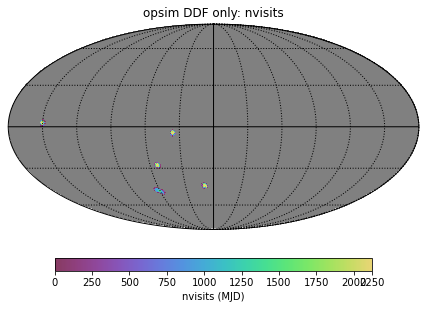

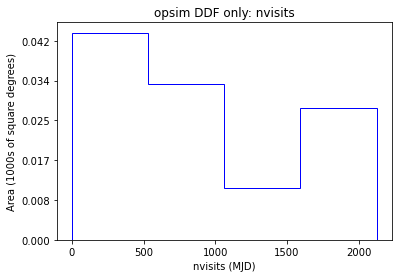

In [10]:
ddf_g = mb.MetricBundleGroup({'0': ddf_bundle}, opsdb, outDir=outDir)
ddf_g.runAll()
ddf_g.plotAll(closefigs=False, savefig=False)

### 2. Compute Metrics on areas outside DDF and WFD

In [11]:
# specify proposal ID use compute metric on DDF only
other_constraint = constraint + ' and proposalId = 0'

# create metric Bundle
other_bundle = mb.MetricBundle(metric, slicer, other_constraint, metadata='Other')

Querying table None with constraint filter = "g" and proposalId = 0 for columns ['observationStartMJD', 'rotSkyPos', 'fieldDec', 'fieldRA']
Found 43710 visits
Running:  ['0']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "filter = "g" and proposalId = 0" constraint now.


0.0 180.0 -180.0 180.0


Plotting complete.


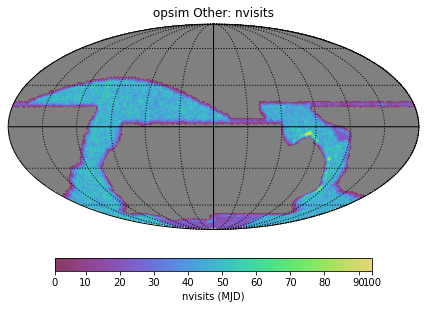

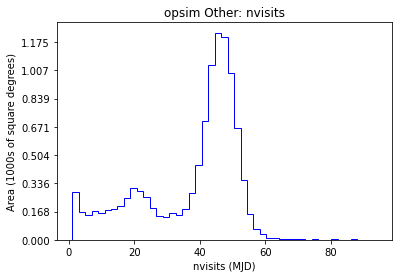

In [12]:
other_g = mb.MetricBundleGroup({'0': other_bundle}, opsdb, outDir=outDir)
other_g.runAll()
other_g.plotAll(closefigs=False, savefig=False)